# Introduction


This work analyzes historic data of KSM, DOT, KINT, USDC and BTC in order to decide on security parameters for the Kintsugi bridge. For assets traded in order-book exchanges, the code is general enough such that inspecting a new collateral asset can be done with minimal effort.

Historic price data is gathered from Coingecko, while order book data is collected from the Binance API. Binance is preferred over the other centralized exchanges because it has by far the largest trading volume (https://coinmarketcap.com/rankings/exchanges/).

The approach from Gudgeon et al's DeFi Crisis paper (https://arxiv.org/pdf/2002.08099.pdf) is applied, which models price trajectories as stochastic processes. In addition, a simple slippage model is used as part of the burn redeem simulation.

The analysed parameters are LIQUIDATION_THRESHOLD and SECURE_THRESHOLD. The bridge also uses a PREMIUM_REDEEM_THRESHOLD to increase system security, but premium redeems are assumed not to occur in order to better capture tail risk.

Vaults are modelled as a single entity that mints the maximum wrapped amount on the first simulated day, at the secure threshold.

One step of the simulation generates multiple price trajectories for both the collateral and wrapped asset, considering their observed correlation. Then, the "worst" trajectory of the collateral asset is picked: where collateral price is lowest with respect to the wrapped aspect on the final day.

If, on any day, vaults fall below the liquidation ratio, their entire collateral is seized by the liquidation vault, causing the 1:1 peg to be destabilised. At this point, the "debt" in the system can only be liquidated by arbitrageurs who burn wrapped tokens in exchange for collateral at a beneficial rate. How beneficial this rate is, is initially decided by the liquidation threshold; but if the backing asset keeps decreasing in value arbitrage profits can reach zero. In the event that the liquidation vault becomes undercollateralized, the relative value of the wrapped tokens to BTC would be equal to the collateralization rate.

Another conservative assumption is that liquidators start minting wrapped tokens only after the peg is destabilized, thus requiring liquidity in both collateral and BTC. Although Gudgeon et al's paper assumes liquidity is equal to the daily traded volume, this works takes the more thorough approach of training a transaction cost (slippage) model. The larger the debt ceiling in the bridge, the more likely it is that liquidiators would move the market. For invidividual KSM trades, which achieve small volumes compared to DOT, there is close to zero correlation between buy order amount (buyer-is-taker) and price movement. However, correlation can be noticed when consecutive buy order are considered (with no sells in-between). After some manual filtering, the slippage model is trained on the most extreme of these data points.


Future improvements:
- Model liquidation behaviour for premium redeem.
- When more kBTC liquidity becomes available, relax assumptions about burn redeem behaviour.
- Replace the Gaussian Brownian Motion model with one that considers clustered volatility.
- The definition of "worst" price trajectory can be improved in the future by focusing on sharp price drops.
- Aggregate trading data from multiple centralized exchanges.
- Use a loss function that priotizes outliers when training the slippage model.
- In a similar work, Gauntlet (https://medium.com/gauntlet-networks/karura-parameter-recommendation-methodology-6ce7fe06cb77) also train a price impact model to measure how quickly the market recovers after large trades. Such a model should be added to this framework too.

# Data reading and processing

In [1]:
# KSM/USD daily (queried 25 April 2022): https://api.coingecko.com/api/v3/coins/kusama/market_chart?vs_currency=usd&days=114
# KINT/USD daily (queried 25 April 2022): https://api.coingecko.com/api/v3/coins/kintsugi/market_chart?vs_currency=usd&days=114
# DOT/USD daily (queried 25 April 2022): https://api.coingecko.com/api/v3/coins/polkadot/market_chart?vs_currency=usd&days=114
#BTC/USD daily (queried 25 April 2022): https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=114
# `./download_trades` script made to download Binance data

In [5]:
import json
from scipy.stats import pearsonr
import math
import datetime

from sklearn import linear_model
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt
import numpy as np
import statistics
import pandas as pd


def get_usd_timeseries(file):
    f = open(file)
    data = json.load(f)
    f.close()
    return [price for (timestamp, price) in data["prices"]]


def get_volume_timeseries(file):
    f = open(file)
    data = json.load(f)
    f.close()
    prices = get_usd_timeseries(file)
    volumes = []
    for i in range(len(data["total_volumes"])):
        (timestamp, usd_volume) = data["total_volumes"][i]
        volumes.append(usd_volume / prices[i])
    return volumes


def get_daily_volumes_dict(file):
    f = open(file)
    data = json.load(f)
    f.close()
    prices = get_usd_timeseries(file)
    volumes = dict()
    for i in range(len(data["total_volumes"])):
        (timestamp, usd_volume) = data["total_volumes"][i]
        volumes[timestamp] = usd_volume
    return volumes


def determine_price_between_assets(asset_1_prices, asset_2_prices):
    return [
        asset_1_price / asset_2_price
        for (asset_1_price, asset_2_price) in zip(asset_1_prices, asset_2_prices)
    ]


def prices_to_returns(prices):
    return [(prices[i] / prices[i - 1] - 1) for i in range(1, len(prices))]


def round_timestamp_to_nearest_gmt_date(unix_timestamp):
    import os

    date_format = "%d/%m/%Y"
    os.environ["TZ"] = "GMT"
    parsed_date = datetime.datetime.fromtimestamp(
        int(unix_timestamp) / 1000.0
    ).strftime(date_format)
    return (
        int(datetime.datetime.strptime(parsed_date, date_format).timestamp() + 3600)
        * 1000
    )


def read_trading_data(file):
    # Assumes Binance format
    # https://github.com/binance/binance-public-data/#trades
    names = [
        "trade_id",
        "price",
        "qty",
        "quote_qty",
        "time",
        "is_buyer_maker",
        "is_best_match",
    ]
    df = pd.read_csv(file, names=names)
    return df.drop(columns=["trade_id", "quote_qty", "is_best_match"])


def clean_trading_data_consecutively(
    trading_data, daily_volumes_dict, max_item_count, min_total_qty, min_price_change
):
    # simplify df to be ready for regression
    cleaned_df = pd.DataFrame(columns=["qty", "caused_price_change"])
    cleaned_df_index = 0
    prev_price = 1
    prev_qty = 0
    prev_nearest_date = 0
    prev_qty_to_volume_ratio = 0
    prev_is_buyer_maker = False
    i = -1
    while i < len(trading_data.index):
        i += 1
        row = trading_data.iloc[i]
        if row["is_buyer_maker"] == True:
            continue
        initial_price = row["price"]
        j = i
        total_qty = 0
        while row["is_buyer_maker"] == False and j < len(trading_data.index):
            row = trading_data.iloc[j]
            total_qty += row["qty"]
            j += 1
        price_change = (row["price"] / initial_price) - 1
        if i == j or total_qty < min_total_qty or price_change < min_price_change:
            continue
        cleaned_df.loc[cleaned_df_index] = [
            total_qty,
            price_change,
        ]
        cleaned_df_index += 1
        print("Added elements: " + str(cleaned_df_index))
        i = j
        if cleaned_df_index > max_item_count:
            break
    return cleaned_df



In [9]:
get_usd_timeseries("data/prices/btc_25_april_2022.json")

[47387.212167697246,
 46531.140860530526,
 45938.02427172366,
 43647.147508068054,
 43216.45867693359,
 41527.197042644846,
 41756.66232397826,
 41862.3609856517,
 41869.85905559219,
 42777.211020482355,
 43981.87732717414,
 42608.41001195019,
 43120.85451108056,
 43226.65026980921,
 43119.79214308028,
 42298.341116872325,
 42395.45879157343,
 41749.55143098559,
 40707.6824143097,
 36508.799789830824,
 35180.435462830384,
 36306.409440464704,
 36774.00714224005,
 36988.928510667356,
 36870.440166930995,
 37276.839558174994,
 37852.57902803263,
 38232.17873217708,
 37983.151499406464,
 38555.53446121157,
 38835.69494322237,
 37000.98249864199,
 37101.351593780935,
 41673.8395543094,
 41493.690050910525,
 42475.543220951215,
 43910.929986443094,
 44184.447511676175,
 44383.88805541707,
 43628.13953235228,
 42445.38876793804,
 42254.738123237206,
 42247.83595326771,
 42634.573783663065,
 44574.32057099816,
 44063.28198279571,
 40562.98694982819,
 40073.495362369824,
 40192.75912143141,
 3

In [8]:
# Read BTC price history
btc_to_usd_daily = get_usd_timeseries("data/prices/btc_25_april_2022.json")
btc_usd_returns_daily = prices_to_returns(btc_to_usd_daily)

# Read KINT price history
kint_to_usd_daily = get_usd_timeseries("data/prices/kint_25_april_2022.json")
kint_usd_returns_daily = prices_to_returns(kint_to_usd_daily)

kint_to_btc_daily = determine_price_between_assets(kint_to_usd_daily, btc_to_usd_daily)
kint_to_btc_returns_daily = prices_to_returns(kint_to_btc_daily)
observed_kint_btc_corr, _ = pearsonr(kint_usd_returns_daily, btc_usd_returns_daily)

# Read USDC price history
usdc_to_usd_daily = get_usd_timeseries("data/prices/usdc_25_april_2022.json")
usdc_usd_returns_daily = prices_to_returns(usdc_to_usd_daily)

usdc_to_btc_daily = determine_price_between_assets(usdc_to_usd_daily, btc_to_usd_daily)
usdc_to_btc_returns_daily = prices_to_returns(usdc_to_btc_daily)
observed_usdc_btc_corr, _ = pearsonr(usdc_usd_returns_daily, btc_usd_returns_daily)

# Read KSM price history
ksm_to_usd_daily = get_usd_timeseries("data/prices/ksm_25_april_2022.json")
ksm_usd_returns_daily = prices_to_returns(ksm_to_usd_daily)

ksm_to_btc_daily = determine_price_between_assets(ksm_to_usd_daily, btc_to_usd_daily)
ksm_to_btc_returns_daily = prices_to_returns(ksm_to_btc_daily)
observed_ksm_btc_corr, _ = pearsonr(ksm_usd_returns_daily, btc_usd_returns_daily)

# Read DOT price history
dot_to_usd_daily = get_usd_timeseries("data/prices/dot_25_april_2022.json")
dot_usd_returns_daily = prices_to_returns(dot_to_usd_daily)

dot_to_btc_daily = determine_price_between_assets(dot_to_usd_daily, btc_to_usd_daily)
dot_to_btc_returns_daily = prices_to_returns(dot_to_btc_daily)
observed_dot_btc_corr, _ = pearsonr(dot_usd_returns_daily, btc_usd_returns_daily)

# Read trading volumes for the liquidity model
ksm_daily_volumes = get_volume_timeseries("data/volumes/kusama_to_usd_daily_2021.json")
ksm_volumes_dict = get_daily_volumes_dict("data/volumes/kusama_to_usd_daily_2021.json")

dot_daily_volumes = get_volume_timeseries("data/volumes/polkadot_to_usd_daily_2021.json")
dot_volumes_dict = get_daily_volumes_dict("data/volumes/polkadot_to_usd_daily_2021.json")

btc_daily_volumes = get_volume_timeseries("data/volumes/bitcoin_to_usd_daily_2021.json")
btc_volumes_dict = get_daily_volumes_dict("data/volumes/bitcoin_to_usd_daily_2021.json")

print("KINT/BTC correlation is: " + str(observed_kint_btc_corr))
print("USDC/BTC correlation is: " + str(observed_usdc_btc_corr))
print("KSM/BTC correlation is: " + str(observed_ksm_btc_corr))
print("DOT/BTC correlation is: " + str(observed_dot_btc_corr))


KINT/BTC correlation is: -0.08819987289396485
USDC/BTC correlation is: 0.04449636301408451
KSM/BTC correlation is: 0.7321293080674566
DOT/BTC correlation is: 0.7992618746064635


In [7]:
btc_raw_trading_data = read_trading_data("data/trades/BTC_trades.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'data/trades/BTC_trades.csv'

In [15]:
# Filter data to only keep extreme cases, to train a conservative slippage model
btc_trading_data = clean_trading_data_consecutively(
    btc_raw_trading_data, btc_volumes_dict, 20, 5, 0.000001
)

Added elements: 1
Added elements: 2
Added elements: 3
Added elements: 4
Added elements: 5
Added elements: 6
Added elements: 7
Added elements: 8
Added elements: 9
Added elements: 10
Added elements: 11
Added elements: 12
Added elements: 13
Added elements: 14
Added elements: 15
Added elements: 16
Added elements: 17
Added elements: 18
Added elements: 19
Added elements: 20
Added elements: 21


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
ksm_raw_trading_data = read_trading_data("data/trades/KSM_trades.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
# Filter data to only keep extreme cases, to train a conservative slippage model
ksm_trading_data = clean_trading_data_consecutively(
    ksm_raw_trading_data, ksm_volumes_dict, 10, 10, 0.006
)

Added elements: 1
Added elements: 2
Added elements: 3
Added elements: 4
Added elements: 5
Added elements: 6
Added elements: 7
Added elements: 8
Added elements: 9
Added elements: 10
Added elements: 11


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
dot_raw_trading_data = read_trading_data("data/trades/DOT_trades.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
# Filter data to only keep extreme case, to train a conservative slippage model
dot_trading_data = clean_trading_data_consecutively(
    dot_raw_trading_data, dot_volumes_dict, 50, 200, 0.0005
)

Added elements: 1
Added elements: 2
Added elements: 3
Added elements: 4
Added elements: 5
Added elements: 6
Added elements: 7
Added elements: 8
Added elements: 9
Added elements: 10
Added elements: 11
Added elements: 12
Added elements: 13
Added elements: 14
Added elements: 15
Added elements: 16
Added elements: 17
Added elements: 18
Added elements: 19
Added elements: 20
Added elements: 21
Added elements: 22
Added elements: 23
Added elements: 24
Added elements: 25
Added elements: 26
Added elements: 27
Added elements: 28
Added elements: 29
Added elements: 30
Added elements: 31
Added elements: 32
Added elements: 33
Added elements: 34
Added elements: 35
Added elements: 36
Added elements: 37
Added elements: 38
Added elements: 39
Added elements: 40
Added elements: 41
Added elements: 42
Added elements: 43
Added elements: 44
Added elements: 45
Added elements: 46
Added elements: 47
Added elements: 48
Added elements: 49
Added elements: 50
Added elements: 51


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

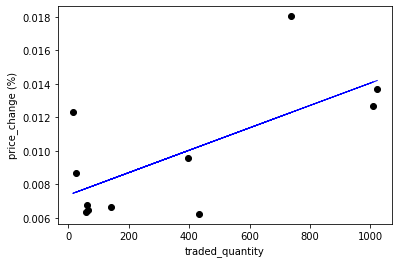

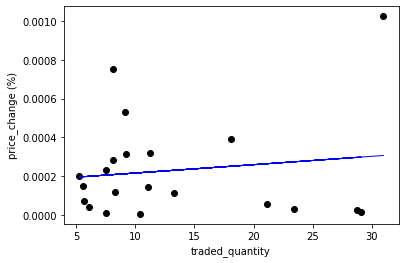

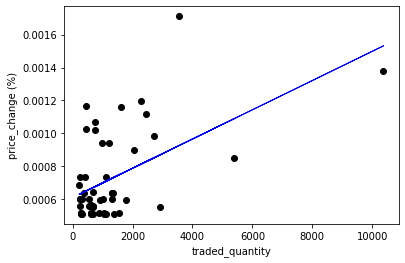

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
def get_regression_model(trading_data, min_price_change=None, max_qty=None):
    filtered_data = trading_data
    if min_price_change and max_qty:
        filtered_data = filtered_data[
            (filtered_data["caused_price_change"] > 0.01) & (filtered_data["qty"] < 400)
        ]
    x = filtered_data.qty.values
    y = filtered_data.caused_price_change.values

    x = x.reshape(len(x), 1)
    y = y.reshape(len(x), 1)

    regr = linear_model.LinearRegression()
    result = regr.fit(x, y)
    model = result.predict
    plt.scatter(x, y, color="black")
    plt.plot(x, model(x), color="blue", linewidth=1)
    plt.ylabel("price_change (%)")
    plt.xlabel("traded_quantity")
    plt.show()
    return model


ksm_liquidity_model = get_regression_model(ksm_trading_data)
btc_liquidity_model = get_regression_model(btc_trading_data)
dot_liquidity_model = get_regression_model(dot_trading_data)

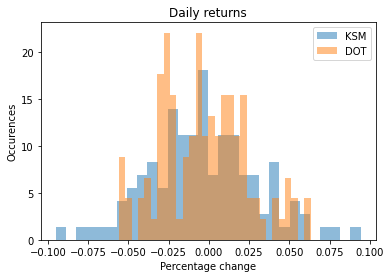

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
def plot_returns(returns, data_label, title):
    plt.hist(returns, density=True, bins=30, alpha=0.5, label=data_label)
    plt.ylabel("Occurences")
    plt.xlabel("Percentage change")
    plt.legend(loc="upper right")
    plt.title(title)


plot_returns(ksm_to_btc_returns_daily, "KSM", "Daily returns")
plot_returns(dot_to_btc_returns_daily, "DOT", "Daily returns")

# Monte Carlo Simulation
https://arxiv.org/pdf/2002.08099.pdf

Independently simulates the prices of collateral and BTC.

Selects the "worst" collateral/USD price trajectory, then picks the BTC/USD price trajectory that has the closest pearson correlation to the one in the real data sample.

All vaults are considered a single entity, but they are separated from the liquidation vault. When vaults become undercollateralized, liquidators acquire as much liquidity as possible to arbitrage, taking slippage into account. Liquidators are assumed ot start up their own vault just before liquidating, so both collateral and Bitcoin liquidity need to be modelled.

In [22]:
SIMULATED_SCENARIOS = 1000
PRICE_PATHS_PER_SIMULATION = 500
PREDICTED_DAYS = 100

# premium redeem is assumed not to occur
PREMIUM_REDEEM_BONUS = 0.05

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
# Monte Carlo price simulation (Geometric Brownian Motion)
# Reference article: https://towardsdatascience.com/simulating-stock-prices-in-python-using-geometric-brownian-motion-8dfd6e8c6b18


def stochastic_price_simulation(
    returns, initial_price, prediction_days, scenario_count
):
    So = initial_price
    dt = 1
    T = prediction_days
    N = T / dt
    t = np.arange(1, int(N) + 1)
    mu = np.mean(returns)
    sigma = np.std(returns)
    scen_size = scenario_count
    b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
    W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}

    # Calculating drift and diffusion components
    drift = (mu - 0.5 * sigma ** 2) * t
    diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}

    # Making the predictions
    S = np.array(
        [So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)]
    )
    S = np.hstack(
        (np.array([[So] for scen in range(scen_size)]), S)
    )  # add So to the beginning series

    # Plotting the simulations
    #     plt.figure(figsize = (20,10))
    #     for i in range(scen_size):
    #         plt.title("Daily Volatility: " + str(sigma))
    #         plt.plot(S[i, :])
    #         plt.ylabel('Price')
    #         plt.xlabel('Prediction Days')
    #     plt.show()
    return S


def get_worst_price_trajectory(S):
    min_price = S[0, -1]
    index = 0
    for i in range(len(S)):
        if S[i, -1] < min_price:
            min_price = S[i, -1]
            index = i
    return S[index, :]


def get_trajectory_with_closest_correlation(S, base_trajectory, corr):
    picked_trajectory = S[0, :]
    index = 0
    closest_found_correlation, _ = pearsonr(base_trajectory, S[0, :])
    for i in range(len(S)):
        tmp_corr, _ = pearsonr(base_trajectory, S[i, :])
        if abs(tmp_corr - corr) < abs(closest_found_correlation - corr):
            closest_found_correlation = tmp_corr
            picked_trajectory = S[i, :]
            index = i
    return S[index, :], closest_found_correlation


def find_profitable_volume(
    secure_threshold,
    collateral_usd,
    btc_usd,
    collateral_liquidity_model,
    btc_liquidity_model,
    liquidation_vault_issued,
    liquidation_vault_collateral,
):
    burn_exchange_rate = (
        (liquidation_vault_collateral * collateral_usd)
        / (liquidation_vault_issued * btc_usd)
        * (collateral_usd / btc_usd)
    )
    btc_amount = liquidation_vault_issued
    while btc_amount > 0:
        collateral_amount = btc_amount * btc_usd / collateral_usd * secure_threshold
        btc_price_change = btc_liquidity_model([[btc_amount]])[0][0]
        collateral_price_change = collateral_liquidity_model([[collateral_amount]])[0][
            0
        ]
        new_btc_price = btc_usd * (1 + btc_price_change)
        new_collateral_price = collateral_usd * (1 + collateral_price_change)
        # assume that if new exchange rate is equal to the burn rate,
        # arbitrageurs stop buying
        new_exchange_rate = new_collateral_price / new_btc_price
        if burn_exchange_rate >= new_exchange_rate:
            return btc_amount
        btc_amount -= 5
    return 0


def get_days_of_undercollateralization(
    worst_collateral_scenario_trajectory,
    correlated_btc_scenario_trajectory,
    collateral_liquidity_model,
    btc_liquidity_model,
    debt_ceiling_usd,
    secure_threshold,
    liquidation_threshold,
):
    starting_collateral_price = worst_collateral_scenario_trajectory[0]
    starting_btc_price = correlated_btc_scenario_trajectory[0]
    vaults_issued = (debt_ceiling_usd / secure_threshold) / starting_btc_price
    vaults_collateral = debt_ceiling_usd / starting_collateral_price

    liquidation_vault_issued = 0
    liquidation_vault_collateral = 0
    current_collateral_to_btc_price = starting_collateral_price / starting_btc_price

    system_collateral_daily = []
    vault_collateral_daily = []
    liquidation_vault_btc_daily = []
    daily_collateralization = []
    days_of_undercollateralization = 0
    for (collateral_usd, btc_usd) in zip(
        worst_collateral_scenario_trajectory, correlated_btc_scenario_trajectory
    ):
        current_collateral_to_btc_price = collateral_usd / btc_usd
        vault_required_collateral = vaults_issued / current_collateral_to_btc_price
        system_required_collateral = (
            vaults_issued + liquidation_vault_issued
        ) / current_collateral_to_btc_price
        system_collateral_daily.append(system_required_collateral)
        vault_collateral_daily.append(vaults_collateral)
        liquidation_vault_btc_daily.append(liquidation_vault_issued)
        system_collateralization = (
            vaults_collateral + liquidation_vault_collateral
        ) / system_required_collateral
        if (
            vaults_issued > 0
            and vaults_collateral / vault_required_collateral < liquidation_threshold
        ):
            # liquidate every vault
            liquidation_vault_issued = vaults_issued
            vaults_issued = 0
            liquidation_vault_collateral = vaults_collateral
            vaults_collateral = 0
        if liquidation_vault_issued > 0:
            btc_arbitrage_amount = find_profitable_volume(
                secure_threshold,
                collateral_usd,
                btc_usd,
                collateral_liquidity_model,
                btc_liquidity_model,
                liquidation_vault_issued,
                liquidation_vault_collateral,
            )

            # mint interbtc for the liquidation
            newly_added_collateral = (
                btc_arbitrage_amount / current_collateral_to_btc_price
            ) * secure_threshold
            vaults_issued += btc_arbitrage_amount
            vaults_collateral += newly_added_collateral

            # perform burn redeem
            burn_exchange_rate = (
                (liquidation_vault_collateral * collateral_usd)
                / (liquidation_vault_issued * btc_usd)
                * current_collateral_to_btc_price
            )
            burn_dot_payout = btc_arbitrage_amount / burn_exchange_rate
            liquidation_vault_issued -= btc_arbitrage_amount
            liquidation_vault_collateral = round(
                liquidation_vault_collateral - burn_dot_payout
            )
        daily_collateralization.append(system_collateralization)
        if system_collateralization < 1:
            days_of_undercollateralization += 1
    return (
        days_of_undercollateralization,
        daily_collateralization,
        liquidation_vault_btc_daily,
    )


def get_worst_pair_of_price_trajectories(
    scenarios_count,
    asset_corr,
    debt_ceiling_usd,
    secure_threshold,
    liquidation_threshold,
    collateral_usd_returns_daily,
    collateral_to_usd_daily,
    collateral_liquidity_model,
    btc_usd_returns_daily,
    btc_to_usd_daily,
    btc_liquidity_model,
):
    worst_btc_trajectory = []
    worst_collateral_trajectory = []
    most_days_of_undercollateralization = 0
    worst_daily_collateralization_trajectory = []
    worst_liquidation_vault_collateral_trajectory = []
    for i in range(scenarios_count):
        collateral_price_simulations = stochastic_price_simulation(
            collateral_usd_returns_daily,
            collateral_to_usd_daily[-1],
            PREDICTED_DAYS,
            PRICE_PATHS_PER_SIMULATION,
        )
        worst_collateral_scenario_trajectory = get_worst_price_trajectory(
            collateral_price_simulations
        )
        btc_price_simulations = stochastic_price_simulation(
            btc_usd_returns_daily,
            btc_to_usd_daily[-1],
            PREDICTED_DAYS,
            PRICE_PATHS_PER_SIMULATION,
        )
        (
            correlated_btc_scenario_trajectory,
            closest_found_correlation,
        ) = get_trajectory_with_closest_correlation(
            btc_price_simulations, worst_collateral_scenario_trajectory, asset_corr
        )
        (
            days_of_undercollateralization,
            daily_collateralization,
            liquidation_vault_btc_daily,
        ) = get_days_of_undercollateralization(
            worst_collateral_scenario_trajectory,
            correlated_btc_scenario_trajectory,
            collateral_liquidity_model,
            btc_liquidity_model,
            debt_ceiling_usd,
            secure_threshold,
            liquidation_threshold,
        )
        if (
            days_of_undercollateralization > most_days_of_undercollateralization
            or most_days_of_undercollateralization == 0
        ):
            most_days_of_undercollateralization = days_of_undercollateralization
            worst_btc_trajectory = correlated_btc_scenario_trajectory
            worst_collateral_trajectory = worst_collateral_scenario_trajectory
            worst_daily_collateralization_trajectory = daily_collateralization
            worst_liquidation_vault_collateral_trajectory = liquidation_vault_btc_daily
    return (
        worst_collateral_trajectory,
        worst_btc_trajectory,
        worst_daily_collateralization_trajectory,
        worst_liquidation_vault_collateral_trajectory,
        most_days_of_undercollateralization,
    )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
%reload_ext nb_black


def plot_collateralization(
    subplot,
    liquidation_vault_issued_daily,
    daily_collateralization,
    liquidation_threshold,
):
    subplot.plot([l / 1000 for l in liquidation_vault_issued_daily])
    subplot.plot(daily_collateralization)
    subplot.plot([liquidation_threshold] * len(daily_collateralization))
    subplot.plot([1.0] * len(daily_collateralization))
    subplot.legend(
        [
            "liquidation_vault_issued (thousands)",
            "collateralization",
            "liquidation threshold",
            "undercollateralization",
        ]
    )


def plot_prices(subplot, collateral_price_trajectory, btc_price_trajectory):
    subplot.plot([price * 1000 for price in collateral_price_trajectory])
    subplot.plot(btc_price_trajectory)
    subplot.legend(["collateral price (x0.001)", "btc price"])


def simulate_and_plot(
    simulated_scenarios,
    observed_collateral_to_btc_corr,
    debt_ceiling_usd,
    secure_threshold,
    liquidation_threshold,
    collateral_usd_returns_daily,
    collateral_to_usd_daily,
    collateral_liquidity_model,
    btc_usd_returns_daily,
    btc_to_usd_daily,
    btc_liquidity_model,
):
    (
        collateral_price_trajectory,
        btc_price_trajectory,
        daily_collateralization,
        liquidation_vault_issued_daily,
        days_of_undercollateralization,
    ) = get_worst_pair_of_price_trajectories(
        simulated_scenarios,
        observed_collateral_to_btc_corr,
        debt_ceiling_usd,
        secure_threshold,
        liquidation_threshold,
        collateral_usd_returns_daily,
        collateral_to_usd_daily,
        collateral_liquidity_model,
        btc_usd_returns_daily,
        btc_to_usd_daily,
        btc_liquidity_model,
    )

    print("days of undercollateralization: " + str(days_of_undercollateralization))
    fig, axs = plt.subplots(2, figsize=(12, 10))
    plot_collateralization(
        axs[0],
        liquidation_vault_issued_daily,
        daily_collateralization,
        liquidation_threshold,
    )
    plot_prices(axs[1], collateral_price_trajectory, btc_price_trajectory)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

days of undercollateralization: 0


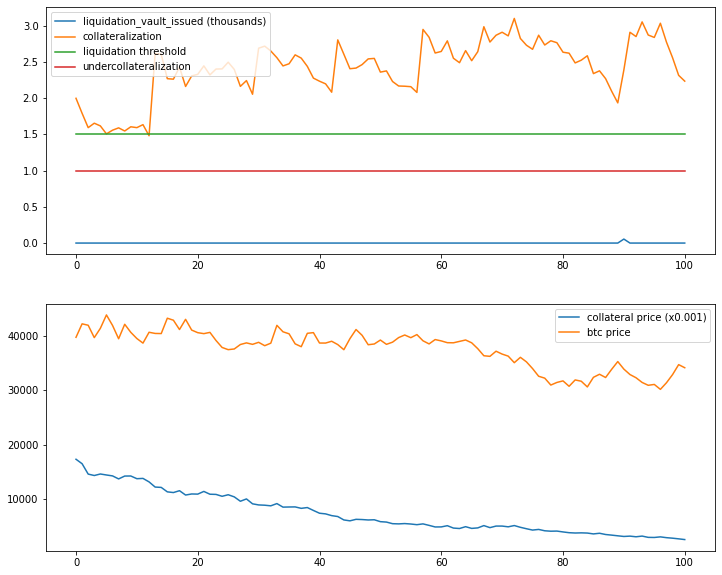

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
DEBT_CEILING_USD = 20_000_000
SECURE_THRESHOLD = 2.0
LIQUIDATION_THRESHOLD = 1.5
simulate_and_plot(
    SIMULATED_SCENARIOS,
    observed_ksm_btc_corr,
    DEBT_CEILING_USD,
    SECURE_THRESHOLD,
    LIQUIDATION_THRESHOLD,
    dot_usd_returns_daily,
    dot_to_usd_daily,
    dot_liquidity_model,
    btc_usd_returns_daily,
    btc_to_usd_daily,
    btc_liquidity_model,
)

days of undercollateralization: 37


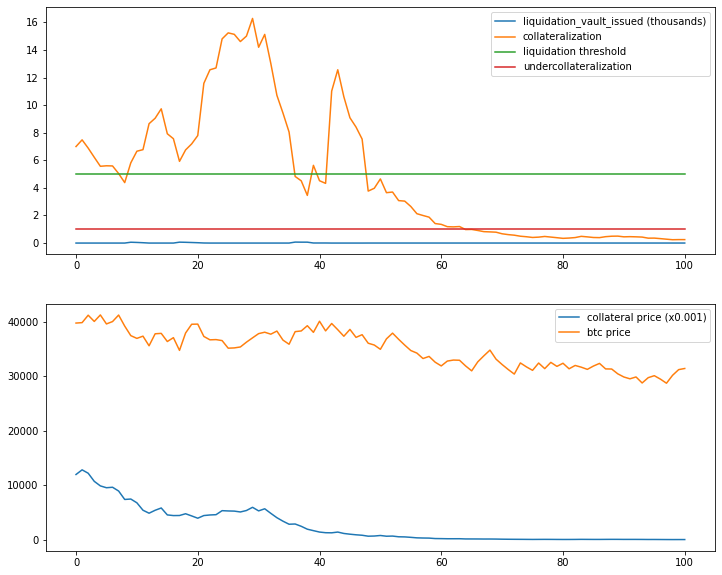

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
# At the moment we don't have data on settled KINT trades.
# Instead, use the KSM liquidity model since it most closely resembles KINT
# of the tokens we already analysed. The market will move favourably for vaults, so it's probably fine.
# However, the fact that market stabilizes after a large trade is not considered.

DEBT_CEILING_USD = 20_000_000
SECURE_THRESHOLD = 7
LIQUIDATION_THRESHOLD = 5
simulate_and_plot(
    SIMULATED_SCENARIOS,
    observed_ksm_btc_corr,
    DEBT_CEILING_USD,
    SECURE_THRESHOLD,
    LIQUIDATION_THRESHOLD,
    kint_usd_returns_daily,
    kint_to_usd_daily,
    ksm_liquidity_model,
    btc_usd_returns_daily,
    btc_to_usd_daily,
    btc_liquidity_model,
)

days of undercollateralization: 0


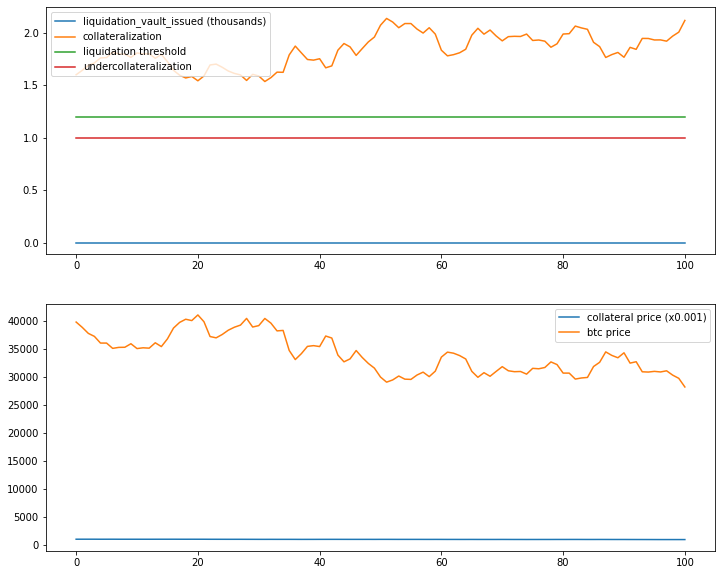

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
# Still need to collect data on settled USDC trades and volumes.
# For now, assume that BTC is more volatile than USDC by using the BTC liquidity
# model for USDC, and the DOT liquidity model for BTC.

DEBT_CEILING_USD = 20_000_000
SECURE_THRESHOLD = 1.6
LIQUIDATION_THRESHOLD = 1.2
simulate_and_plot(
    SIMULATED_SCENARIOS,
    observed_ksm_btc_corr,
    DEBT_CEILING_USD,
    SECURE_THRESHOLD,
    LIQUIDATION_THRESHOLD,
    usdc_usd_returns_daily,
    usdc_to_usd_daily,
    btc_liquidity_model,
    btc_usd_returns_daily,
    btc_to_usd_daily,
    dot_liquidity_model,
)

days of undercollateralization: 8


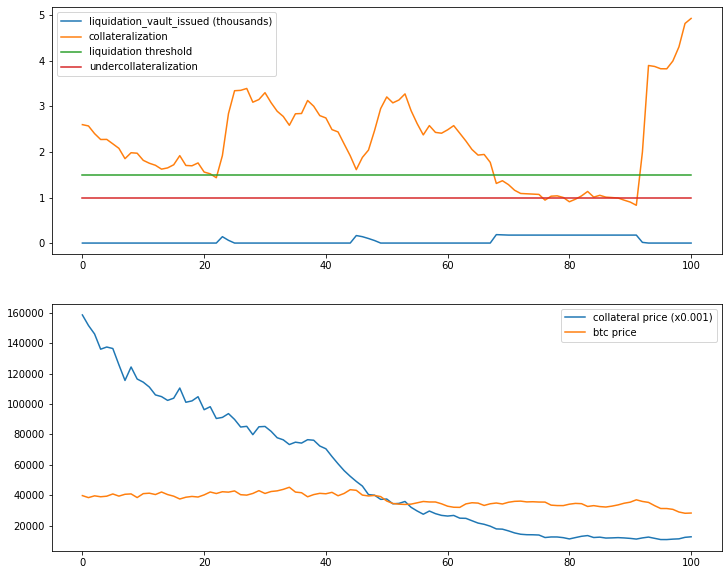

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
DEBT_CEILING_USD = 20_000_000
SECURE_THRESHOLD = 2.6
LIQUIDATION_THRESHOLD = 1.5
simulate_and_plot(
    SIMULATED_SCENARIOS,
    observed_ksm_btc_corr,
    DEBT_CEILING_USD,
    SECURE_THRESHOLD,
    LIQUIDATION_THRESHOLD,
    ksm_usd_returns_daily,
    ksm_to_usd_daily,
    ksm_liquidity_model,
    btc_usd_returns_daily,
    btc_to_usd_daily,
    btc_liquidity_model,
)

days of undercollateralization: 0


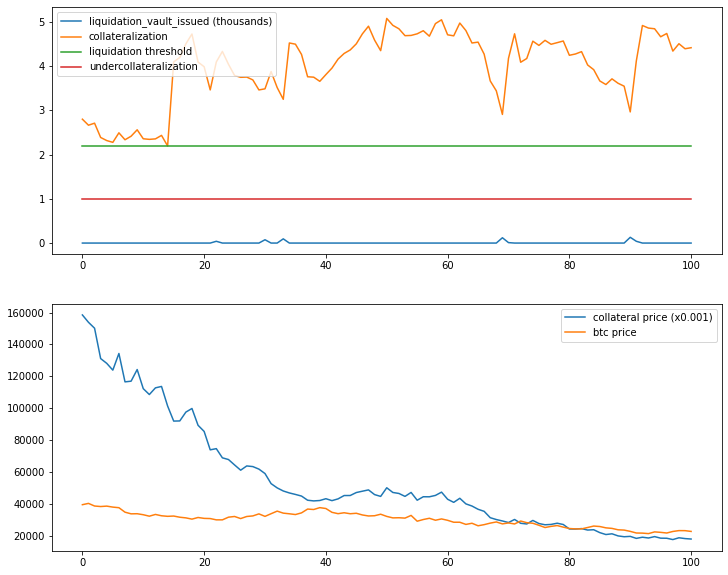

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
DEBT_CEILING_USD = 20_000_000
SECURE_THRESHOLD = 2.8
LIQUIDATION_THRESHOLD = 2.2
simulate_and_plot(
    SIMULATED_SCENARIOS,
    observed_ksm_btc_corr,
    DEBT_CEILING_USD,
    SECURE_THRESHOLD,
    LIQUIDATION_THRESHOLD,
    ksm_usd_returns_daily,
    ksm_to_usd_daily,
    ksm_liquidity_model,
    btc_usd_returns_daily,
    btc_to_usd_daily,
    btc_liquidity_model,
)

# Value At Risk (VAR) Model
At the moment now used, but can compare results with the Monte Carlo simulation.

https://ocw.mit.edu/courses/mathematics/18-s096-topics-in-mathematics-with-applications-in-finance-fall-2013/lecture-notes/MIT18_S096F13_lecnote7.pdf

In [30]:
def get_var(bid_ask_spread, threshold, daily_returns):
    confidence_99_9 = 3.29
    confidence_99 = 2.57
    confidence_95 = 1.96
    # Compute stddev using the daily returns, as these have higher volatility than hourly returns.
    # VaR underestimates the number of large market moves.
    # Could consider a higher confidence interval to be on the safe side.
    std_dev = statistics.pstdev(daily_returns)
    expected_loss_percentage_99_9 = confidence_99_9 * std_dev * (bid_ask_spread / 2 + 1)
    expected_loss_percentage_99 = confidence_99 * std_dev * (bid_ask_spread / 2 + 1)
    expected_loss_percentage_95 = confidence_95 * std_dev * (bid_ask_spread / 2 + 1)
    print(
        "99.9% confidence interval max price drop (%): "
        + str(expected_loss_percentage_99_9 * 100)
    )
    required_collateralization_99_9 = threshold / (1 - expected_loss_percentage_99_9)
    required_collateralization_99 = threshold / (1 - expected_loss_percentage_99)
    required_collateralization_95 = threshold / (1 - expected_loss_percentage_95)
    print("Liquidation threshold assumption: " + str(threshold))
    print(
        "Required collateralization (99.9% confidence interval): "
        + str(required_collateralization_99_9)
    )
    print(
        "Required collateralization (99% confidence interval): "
        + str(required_collateralization_99)
    )
    print(
        "Required collateralization (95% confidence interval): "
        + str(required_collateralization_95)
    )


DOT_BTC_bid_ask_spread = 0.001
DOT_PREMIUM_REDEEM_THRESHOLD = 2.6
print("DOT VaR results")
get_var(DOT_BTC_bid_ask_spread, DOT_PREMIUM_REDEEM_THRESHOLD, dot_to_btc_returns_daily)
print()
print("KSM VaR results")
KSM_BTC_bid_ask_spread = 0.003
KSM_PREMIUM_REDEEM_THRESHOLD = 2.8
get_var(KSM_BTC_bid_ask_spread, KSM_PREMIUM_REDEEM_THRESHOLD, ksm_to_btc_returns_daily)

DOT VaR results
99.9% confidence interval max price drop (%): 8.808398633769164
Liquidation threshold assumption: 2.6
Required collateralization (99.9% confidence interval): 2.8511397552481257
Required collateralization (99% confidence interval): 2.7921179514550842
Required collateralization (95% confidence interval): 2.743992563786833

KSM VaR results
99.9% confidence interval max price drop (%): 11.151683107514648
Liquidation threshold assumption: 2.8
Required collateralization (99.9% confidence interval): 3.151438426670769
Required collateralization (99% confidence interval): 3.0671887362332777
Required collateralization (95% confidence interval): 2.9992573376251817


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>